In [11]:
# import dependencies
import os
import cv2
#import image generator
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import random
import numpy as np
import matplotlib.pyplot as plt
from Symbol_Detector import Symbol_Detector

In [5]:
# circle-0 
# down-triangle-1 
# square-2 
# up-triangle-3 

# load data
def load_data(path):
    X = []
    Y = []
    label = 0
    for classes in os.listdir(path):
        for file in os.listdir(os.path.join(path, classes)):
            img = cv2.imread(os.path.join(path, classes, file))
            img = cv2.resize(img, (50, 50))
            X.append(img)
            Y.append(label)
        label += 1
    return X,Y

# show data
def show_data(X):
    plt.figure(figsize=(10, 10))
    for i in range(9):
        plt.subplot(3, 3, i+1)
        plt.imshow(X[i])
        plt.axis('off')
        print(X[i].shape)
        print(X[i].dtype)
    plt.show()

In [ ]:

# genertate data using image generator for array of cv2 images
def generate_data(sources_file, dest_file, num_copies):
    # create image generator
    datagen = ImageDataGenerator(
        rotation_range=10,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest')

    # load images
    X, Y = load_data(sources_file)

    # create directory
    if not os.path.exists(dest_file):
        os.mkdir(dest_file)
        
    # create subdirectory for each class
    classes = ['circle', 'down-triangle', 'square', 'up-triangle']
    for i in range(4):
        if not os.path.exists(os.path.join(dest_file, classes[i])):
            os.mkdir(os.path.join(dest_file, classes[i]))

    # generate images
    for i in range(len(X)):
        img = X[i]
        img = img.reshape((1,) + img.shape)
        j = 0
        for batch in datagen.flow(img, batch_size=1, save_to_dir=os.path.join(dest_file, classes[Y[i]]), save_prefix='img', save_format='png'):
            j += 1
            if j > num_copies:
                break

# generate data
# generate_data('data/raw/orignal/', 'data/raw/generated/', 4)

# # load data
# X, Y = load_data('data/raw/generated/')
X, Y = load_data('data/raw/orignal/')

# show data
show_data(X)
print(Y)


In [6]:
# preprocess data
def format_img(data):
    data = np.array(data)
    data = data.astype('float32')
    data = data / 255.0
    return data

def filter_data(X):
    filtered_data = []
    for img in X:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = cv2.GaussianBlur(img, (5, 5), 0)
        filtered_data.append(img)
    return filtered_data

def preprocess_data(source_file, dest_file):
    X, Y = load_data(source_file)
    X = filter_data(X)
    X = format_img(X)
    np.save(os.path.join(dest_file, 'X.npy'), X)
    np.save(os.path.join(dest_file, 'Y.npy'), Y)

# preprocess data
preprocess_data('data/raw/orignal', 'data/processed')

In [9]:
# split data into training and testing sets
def split_data(X, Y, test_size):
    X = np.array(X)
    Y = np.array(Y)
    data = list(zip(X, Y))
    random.shuffle(data)
    X, Y = zip(*data)
    X = np.array(X)
    Y = np.array(Y)
    split = int(len(X) * test_size)
    X_train = X[split:]
    Y_train = Y[split:]
    X_test = X[:split]
    Y_test = Y[:split]
    return X_train, Y_train, X_test, Y_test

In [12]:
# call hyperparameter tuning class and plot accuracy and loss for each hyperparameter combination
import tensorflow as tf
from tensorflow import keras
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.metrics import top_k_categorical_accuracy
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from sklearn.model_selection import train_test_split
X = np.load('data/processed/X.npy')
Y = np.load('data/processed/Y.npy')
# split data
X_train, Y_train, X_test, Y_test = split_data(X, Y, 0.2)

X_train, X_eval, Y_train, Y_eval = train_test_split(X_train, Y_train, random_state=0, train_size = .80)
num_classes = 4
imheight, imwidth = 50, 50
Y_train = keras.utils.to_categorical(Y_train, num_classes)
Y_eval = keras.utils.to_categorical(Y_eval, num_classes)

In [69]:

# This Block is responsible for creating a CNN and fitting the data
epoch_number = 10

model = Sequential()
model.add(Conv2D(32, kernel_size=(5, 5), padding='same', activation='relu', input_shape=(imheight, imwidth, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(728, activation='relu'))
# model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='softmax'))
# model.add(Dense(num_classes, activation='softmax', kernel_regularizer='l1'))

model.summary()

optimize = keras.optimizers.Adam(learning_rate = 0.001) 
model.compile(loss='categorical_crossentropy',
              optimizer=optimize,
              metrics=['accuracy'])

stopper = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=5)
callback_list = [stopper]

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_66 (Conv2D)          (None, 50, 50, 32)        832       
                                                                 
 max_pooling2d_66 (MaxPoolin  (None, 25, 25, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_67 (Conv2D)          (None, 25, 25, 64)        18496     
                                                                 
 max_pooling2d_67 (MaxPoolin  (None, 12, 12, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_68 (Conv2D)          (None, 12, 12, 64)        36928     
                                                                 
 max_pooling2d_68 (MaxPoolin  (None, 6, 6, 64)       

In [70]:
# This Block is responsible for training the model
history_model = model.fit(x=X_train, y=Y_train,
          batch_size = 32,
          epochs = epoch_number,
          validation_data = (X_eval, Y_eval),
          verbose = 1, callbacks=callback_list)

Epoch 1/10
38/38 [==============================] - 9s 189ms/step - loss: 1.3758 - accuracy: 0.3237 - val_loss: 1.3014 - val_accuracy: 0.4375
Epoch 2/10
38/38 [==============================] - 7s 178ms/step - loss: 1.1288 - accuracy: 0.5470 - val_loss: 0.9797 - val_accuracy: 0.6316
Epoch 3/10
38/38 [==============================] - 7s 181ms/step - loss: 0.8034 - accuracy: 0.7059 - val_loss: 0.7125 - val_accuracy: 0.7697
Epoch 4/10
38/38 [==============================] - 7s 189ms/step - loss: 0.5899 - accuracy: 0.8031 - val_loss: 0.5813 - val_accuracy: 0.8125
Epoch 5/10
38/38 [==============================] - 7s 176ms/step - loss: 0.5028 - accuracy: 0.8163 - val_loss: 0.5084 - val_accuracy: 0.8388
Epoch 6/10
38/38 [==============================] - 7s 175ms/step - loss: 0.4035 - accuracy: 0.8608 - val_loss: 0.4631 - val_accuracy: 0.8289
Epoch 7/10
38/38 [==============================] - 7s 172ms/step - loss: 0.3623 - accuracy: 0.8699 - val_loss: 0.4392 - val_accuracy: 0.8586
Epoch 

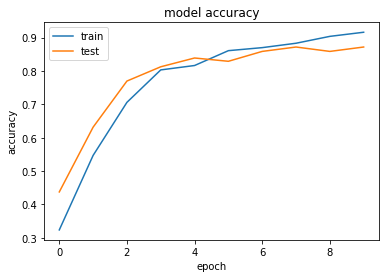

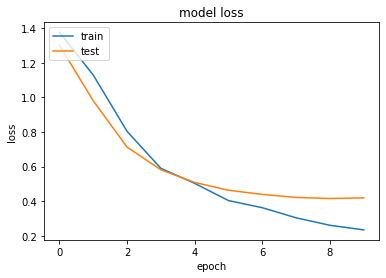

In [71]:
#plot the accuracy and loss for each epoch
plt.plot(history_model.history['accuracy'])
plt.plot(history_model.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history_model.history['loss'])
plt.plot(history_model.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()



In [76]:
# This Block is responsible for evaluating the model
Y_test2 = keras.utils.to_categorical(Y_test, num_classes)
score = model.evaluate(X_test, Y_test2, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])



Test loss: 0.4563731849193573
Test accuracy: 0.8337730765342712


In [77]:
# This Block is responsible for saving the model
model_json = model.to_json()
with open("data/model/model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5 
model.save_weights("data/model/model.h5")
print("Saved model to disk")



Saved model to disk


In [3]:
# json to model 
from tensorflow.keras.models import model_from_json

# This Block is responsible for loading the model
json_file = open('data/model/model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("data/model/model.h5")
print("Loaded model from disk")



Loaded model from disk


In [14]:

# This Block is responsible for predicting the model
# predict probabilities for test example
pred = loaded_model.predict(X_test[0].reshape(1, 50, 50, 1)) 
print(pred)
print(X_test[0].shape)


1/1 [==============================] - 0s 116ms/step
[[9.2473958e-05 2.3151701e-02 3.0806108e-04 9.7644776e-01]]
(50, 50)
